In [1]:
# coding: utf8

In [2]:
import math
import random
import pandas as pd
import numpy  as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
from __future__ import division
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

In [4]:
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
sb.set(style="white", color_codes=True)

In [5]:
SEED_STATE = 1
KFOLDS_NUM = 8

In [6]:
# TODO define the cost function
def kaggleLogLoss(np_target, np_predict):
    """
    """
    np_target = np.array(np_target.tolist())
    np_predict = np.array(np_predict.tolist())
    
    def limit(p):
        return max(min(p,1e-15),1 - 1e-15)
    
    predict = []
    for idx, p in enumerate(np_predict):
        predict.append(limit(p))
    predict = np.array(predict)
    
    t1 = np.prod([np_target, np.log(predict)], axis=0)
    t2 = np.prod([(1 - np_target),(1 - np.log(predict))], axis=0)
    
    return sum(np.sum([t1, t2], axis=0)) / len(np_target) 


## Loading the data

In [9]:
claims = pd.read_csv('train.csv')

In [10]:
claims.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


#### Do we have only numerical values ?

In [11]:
null_serie = claims.isnull().sum()
claims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114321 entries, 0 to 114320
Columns: 133 entries, ID to v131
dtypes: float64(108), int64(6), object(19)
memory usage: 116.9+ MB


#### Is the dataset is balanced ?

Number of safe approval :  87021
Number of risky approval:  27300


([<matplotlib.patches.Wedge at 0x101bf3450>,
  <matplotlib.text.Text at 0x10c314f10>])

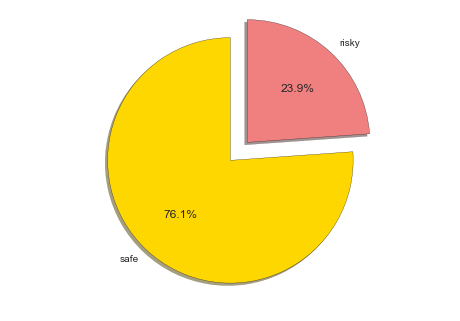

In [12]:
df_ones = claims [claims["target"] == 1]
df_zeros = claims [claims["target"] == 0]

print "Number of safe approval : ", len(df_ones)
print "Number of risky approval: ",len(df_zeros)
plt.axis('equal')
plt.pie([len(df_ones), len(df_zeros)], labels=["safe", "risky"],
        colors=['gold', 'lightcoral'], autopct='%1.1f%%', shadow=True,
        startangle=90, explode = (0, 0.2))


#### Do have missing values ?!

In [13]:
print "Number of missing values:\t",null_serie["v7"]
print "Number of real values:\t",len(claims["v7"].dropna())
claims["v12"].describe()

Number of missing values:	49832
Number of real values:	64489


count    1.142350e+05
mean     6.881304e+00
std      9.244945e-01
min      5.143224e-07
25%      6.322471e+00
50%      6.612969e+00
75%      7.019983e+00
max      1.871055e+01
Name: v12, dtype: float64

In [14]:
all_features = claims.drop(["ID", "target"] ,axis=1).columns
dict_types = all_features.to_series().groupby(claims.dtypes).groups
dict_types = {k.name: v for k, v in dict_types.items()}
print "Here the differents types columns in the df: ",dict_types.keys()
int_columns = dict_types[u'int64']
cat_columns = dict_types[u'object']
float_columns = dict_types[u'float64']
print "Number of interger columns: \t ",len(int_columns)
print "Number of letters  columns: \t ",len(cat_columns)

Here the differents types columns in the df:  ['object', 'int64', 'float64']
Number of interger columns: 	  4
Number of letters  columns: 	  19


In [15]:
#sb.boxplot(x="target", y="v72", data=claims[int_columns + ["target"]])
#claims[int_columns + ["target"]].boxplot(by="target")

## Cleaning the Data

In [16]:
df_ones_drop, df_ones_keep = train_test_split(df_ones, test_size=0.32, random_state=SEED_STATE) 
print "Simple claim(%i) vs Risky claims(%i)"%(len(df_ones_keep),len(df_zeros))

Simple claim(27847) vs Risky claims(27300)


([<matplotlib.patches.Wedge at 0x10c341ad0>,
  <matplotlib.text.Text at 0x10c35ac90>])

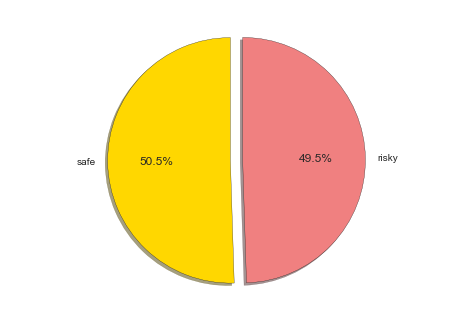

In [17]:
plt.axis('equal')
plt.pie([len(df_ones_keep), len(df_zeros)], labels=["safe", "risky"],
        colors=['gold', 'lightcoral'], autopct='%1.1f%%', shadow=True,
        startangle=90, explode = (0, 0.1))

In [18]:
claims.head(5)

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
80106,159983,0,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AK,NaN,NaN,NaN,0,NaN,NaN
85173,170083,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,BD,NaN,NaN,NaN,0,NaN,NaN
53398,106729,1,0.522894,6.551627,NaN,6.141825,10.209255,2.634257,2.719050,0.862119,...,6.633663,1.844494,2.505030e-01,AK,2.204729,2.734595,3.090974,0,0.923077,0.900900
66390,132477,0,2.029251,11.593458,C,5.066750,8.957633,2.266911,3.046922,0.065173,...,5.343511,1.801544,8.257478e-02,BW,1.522677,2.239488,2.716741,0,0.768001,3.750000
3886,7738,1,2.032036,7.153166,C,3.789430,6.570276,1.812357,2.132723,0.091289,...,8.396947,3.527629,5.767355e-07,BE,1.203240,3.398169,1.253247,1,2.163089,1.904761


In [19]:
float_claims = claims[float_columns + ["ID", "target"]]

In [36]:
col_dead =  float_claims.isnull().sum()
col_dead.sort()
print "Here are the 3 col with the more missing values",col_dead[-3:].index.tolist()

 Here are the 3 col with the more missing values ['v119', 'v85', 'v102']


In [20]:
def ramdom_fill(column_items):
    """
    """
    final_col = []
    real = column_items[1].copy()
    real = real.dropna().tolist()
    
    #description = column_items[1].describe()
   
    #std = description["std"]
    #mean = description["mean"]
    
    for i, element in enumerate(column_items[1]):
        if math.isnan(element):
            r = random.randint(0, len(real)-1)
            final_col.append(0)
        else:
            final_col.append(element)

    return pd.Series(final_col, index=column_items[1].index.tolist())    

In [21]:
### Start cleaning

In [22]:
for item in float_claims.iteritems():
    float_claims[item[0]] = float_claims[item[0]].fillna(item[1].mean())

In [23]:
float_claims.head(5)

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v122,v123,v124,v126,v127,v128,v130,v131,ID,target
80106,1.633798,7.412986,4.106904,8.720868,2.425609,2.469036,1.526655,9.036545,1.050327,15.446440,...,6.815795,3.631367,9.345157e-01,1.672753,3.224474,2.015928,1.957429,1.718859,159983,0
85173,1.633798,7.412986,4.106904,8.720868,2.425609,2.469036,1.526655,9.036545,1.969366,15.446440,...,6.815795,3.631367,9.345157e-01,1.672753,3.224474,2.015928,1.957429,1.718859,170083,1
53398,0.522894,6.551627,6.141825,10.209255,2.634257,2.719050,0.862119,8.712871,6.564552,15.454546,...,6.633663,1.844494,2.505030e-01,2.204729,2.734595,3.090974,0.923077,0.900900,106729,1
66390,2.029251,11.593458,5.066750,8.957633,2.266911,3.046922,0.065173,7.022901,2.078774,15.979112,...,5.343511,1.801544,8.257478e-02,1.522677,2.239488,2.716741,0.768001,3.750000,132477,0
3886,2.032036,7.153166,3.789430,6.570276,1.812357,2.132723,0.091289,10.687022,3.916850,15.297619,...,8.396947,3.527629,5.767355e-07,1.203240,3.398169,1.253247,2.163089,1.904761,7738,1


In [24]:
float_claims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55147 entries, 80106 to 40352
Columns: 110 entries, v1 to target
dtypes: float64(108), int64(2)
memory usage: 46.7 MB


In [25]:
train_float_claim, test_float_claim = train_test_split(float_claims, 
                                                       test_size=0.2, 
                                                       random_state=SEED_STATE) 

In [26]:
Boost = GradientBoostingClassifier(n_estimators=10,
                                   max_depth=50, 
                                   random_state=SEED_STATE)

In [27]:
Boost.fit(train_float_claim.drop(["ID", "target"], axis=1) , train_float_claim["target"])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=50, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
test_x = test_float_claim.drop(["ID", "target"], axis=1)
test_y = test_float_claim["target"]

In [29]:
#Boost.score(test_x, test_y)

In [30]:
help(Boost.predict_proba)

Help on method predict_proba in module sklearn.ensemble.gradient_boosting:

predict_proba(self, X) method of sklearn.ensemble.gradient_boosting.GradientBoostingClassifier instance
    Predict class probabilities for X.
    
    Parameters
    ----------
    X : array-like of shape = [n_samples, n_features]
        The input samples.
    
    Raises
    ------
    AttributeError
        If the ``loss`` does not support probabilities.
    
    Returns
    -------
    p : array of shape = [n_samples]
        The class probabilities of the input samples. The order of the
        classes corresponds to that in the attribute `classes_`.



In [31]:
result = test_float_claim[["ID", "target"]]
result["PredictedProb"] = Boost.predict_proba(test_x)[:,1].tolist()

In [51]:
result.head(4)

,ID,target,PredictedProb
61234,122251,0,0.638849
49687,99252,1,0.822651
102089,204055,1,0.498604
99167,198222,0,0.433890


In [33]:
kaggleLogLoss(result["target"], result["PredictedProb"])

-0.49755213055303715

In [34]:
submition = pd.read_csv('test.csv')

In [35]:
submition.head(5)

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,0,1.375465e+00,11.361141,C,4.200778,6.57700,2.081784,1.784386,0.011094,9.523810,...,7.619048,1.815241,1.112270e-07,AF,1.292368,3.903345,1.485925,0,2.333334,1.428572e+00
1,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,NaN,NaN,0,NaN,NaN
2,2,-4.903407e-07,8.201529,C,4.544371,6.55010,1.558442,2.467532,0.007164,7.142858,...,5.714286,1.970928,1.412265e-02,AV,1.128724,5.844156,1.475892,0,1.263157,-6.380022e-07
3,7,2.661870e+00,3.041241,C,1.657216,9.77308,2.078337,1.430855,1.252157,7.959596,...,4.404040,8.163614,1.100329e+00,B,1.988688,1.558753,2.448814,0,5.385474,1.493777e+00
4,10,1.252822e+00,11.283352,C,4.638388,8.52051,2.302484,3.510159,0.074263,7.612904,...,6.580644,1.325654,2.584588e-01,A,1.863796,2.666478,2.374275,0,0.681672,2.264151e+00


In [ ]:

cv_set = StratifiedKFold(float_claims.index.tolist(), KFOLDS_NUM, random_state=SEED_STATE)

verbose = False 
cross_train_error = []
cross_valid_error = []

estimators = 20
# ct -> cross_train
# cv -> cross_valid

iterration = 0
cv_iterration = 0

for param in range(0,10,1):
    if(verbose): print "========= Running Cross Validation on estimators: ",estimators
    cv_iterration = train_score = valid_score = 0
    iterration = iterration + 1
    
    for ct, cv in cv_set:
        cv_iterration = cv_iterration + 1

    
        if(verbose): print "::::::::: Running Cross Validation," + \
        "iteration n°%i, use value: %i :::::::::"%(cv_iterration, param)
    
        cross_train_set = float_claims[float_claims.index.isin(ct)]
        cross_valid_set = float_claims[float_claims.index.isin(cv)]
    
        #cross_forest = RandomForestClassifier(n_estimators=estimators,
        #                                      max_depth=10,
        #                                      min_samples_split=50,
        #                                      random_state=1)
    
        #cross_forest.fit(cross_train_set.drop(target, axis=1), cross_train_set[target])
    
        train_score = train_score + cross_forest.score(
            cross_train_set.drop(target, axis=1), 
            cross_train_set[target])
        
        valid_score = valid_score + cross_forest.score(
            cross_valid_set.drop(target, axis=1), 
            cross_valid_set[target])
    
    
    train_error = 1 - (train_score / 10)
    test_error = 1 - (valid_score / 10)
    
    print "Iterration n° %i => Estimator: %i Sum of errors"%(cv_iterration, estimators) + \
    " train(%.3f) , valid(%.3f) "%(train_error, test_error)
    cross_train_error.append(train_error)#/cross_vadlidation_set.n_folds)
    cross_valid_error.append(test_error)#/cross_vadlidation_set.n_folds)

minerr = min(cross_valid_error)
minerr_idx = cross_valid_error.index(minerr)
print "========= End of the Crossvalidation over estimators"
print "========= The minimum vaidation error: (idx: %i, err: %.3f)"%(minerr_idx, minerr)